In [34]:
    %matplotlib inline
import pandas as pd
import numpy as np
import time 
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from datetime import datetime
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
sns.set(color_codes=True)

## Data Cleaning

In [2]:
rawData = pd.read_csv('data/SqlMetric_prepared.csv')
rawData.head()

,Event Name,Time MSec,Process Name,criteria,DURATION_MSEC,metrics,timestamp,usn,viewName,ActivityID
0,UIServerEventSource/LoadDataStart/Start,2518.457,Process(2920) (2920),Key_backup_policy_tag_73391121-b001-4a9a-b2b2-...,NaN,Table_1:47 Table_2:476 Table_3:199 Table_4:56,11/15/2019 9:51,0,Procedure_0,NaN
1,UIServerEventSource/LoadDataStop/Stop,2621.028,Process(2920) (2920),Key_backup_policy_tag_73391121-b001-4a9a-b2b2-...,102.572,Table_1:47 Table_2:476 Table_3:199 Table_4:56,11/15/2019 9:51,0,Procedure_0,NaN
2,UIServerEventSource/LoadDataStart/Start,2621.106,Process(2920) (2920),Key_@row_session_id_00000000-0000-0000-0000-00...,NaN,Table_1:47 Table_2:476 Table_3:199 Table_4:56,11/15/2019 9:51,0,Procedure_1,NaN
3,UIServerEventSource/LoadDataStop/Stop,2700.351,Process(2920) (2920),Key_@row_session_id_00000000-0000-0000-0000-00...,79.245,Table_1:47 Table_2:476 Table_3:199 Table_4:56,11/15/2019 9:51,0,Procedure_1,NaN
4,UIServerEventSource/LoadDataStart/Start,2700.375,Process(2920) (2920),Key,NaN,Table_1:47 Table_2:476 Table_3:199 Table_4:56,11/15/2019 9:51,0,Procedure_2,NaN


In [3]:
rawData.drop(['ActivityID', 'Event Name', 'criteria', 'Process Name'], axis=1, inplace=True)

In [4]:
rawData.isnull().sum()

Time MSec             0
DURATION_MSEC    173975
metrics               0
timestamp             0
usn                   0
viewName              0
dtype: int64

In [5]:
rawData.dropna(inplace=True)
print(rawData.isnull().sum())
print('Dataset shape: {}'.format(rawData.shape))

Time MSec        0
DURATION_MSEC    0
metrics          0
timestamp        0
usn              0
viewName         0
dtype: int64
Dataset shape: (173974, 6)


In [6]:
rawData.head()

,Time MSec,DURATION_MSEC,metrics,timestamp,usn,viewName
1,2621.028,102.572,Table_1:47 Table_2:476 Table_3:199 Table_4:56,11/15/2019 9:51,0,Procedure_0
3,2700.351,79.245,Table_1:47 Table_2:476 Table_3:199 Table_4:56,11/15/2019 9:51,0,Procedure_1
5,2701.448,1.073,Table_1:47 Table_2:476 Table_3:199 Table_4:56,11/15/2019 9:51,0,Procedure_2
7,6288.764,"3,587.28",Table_1:47 Table_2:476 Table_3:199 Table_4:56,11/15/2019 9:51,0,Procedure_3
9,6386.315,97.403,Table_1:47 Table_2:476 Table_3:199 Table_4:56,11/15/2019 9:51,"76,986",Procedure_4


In [7]:
rawData['db_state'] = rawData['metrics'].apply(lambda x: x.split(' '))
rawData.drop(['metrics'], axis=1, inplace=True)
print('Dataset shape: {}'.format(rawData.shape))
row = rawData.iloc[0,5]
print('Metrics: {}'.format(row))

dic = {}

for st in row:
    splitted = st.split(':')
    key = splitted[0] 
    dic[key] = [] 
    
print('Parsing sql metrics')
for index, row in rawData.iterrows():
    metrics_row = row['db_state']
    for i in range(0,4):
        st = metrics_row[i]
        splitted = st.split(':')
        key = 'Table_{}'.format(i+1)
        val = np.NaN   
        if len(splitted)>1:
            val = int(splitted[1])
        
        dic[key].append(val)
        

print('Adding new metrics collumns')     
for key in dic.keys():
    rawData[key] = dic[key]

print('Drop db_state column')
rawData.drop(['db_state'], axis=1, inplace=True)
    
print('Parsing sql metrics finnised')
print('Dataset shape: {}'.format(rawData.shape))

Dataset shape: (173974, 6)
Metrics: ['Table_1:47', 'Table_2:476', 'Table_3:199', 'Table_4:56']
Parsing sql metrics
Adding new metrics collumns
Drop db_state column
Parsing sql metrics finnised
Dataset shape: (173974, 9)


In [8]:
print(rawData.isnull().sum())

Time MSec           0
DURATION_MSEC       0
timestamp           0
usn                 0
viewName            0
Table_1          4844
Table_2          4844
Table_3          4844
Table_4          4844
dtype: int64


In [9]:
rawData.dropna(inplace=True)
print('Dataset shape: {}'.format(rawData.shape))

Dataset shape: (169130, 9)


In [10]:
rawData = rawData.applymap(lambda x: x.replace(',','') if type(x) is str or type(x) is object else x)
rawData['is_cold_start'] = rawData['usn'].apply(lambda x: True if int(x) == 0 else False)
rawData.drop(['usn', 'timestamp'], axis=1, inplace=True)
rawData.rename(columns={'Time MSec': 'timestamp', 'DURATION_MSEC': 'duration'}, inplace=True)
rawData['duration'] = rawData['duration'].apply(lambda x: float(x))
print(rawData.isnull().sum())
rawData.head()

timestamp        0
duration         0
viewName         0
Table_1          0
Table_2          0
Table_3          0
Table_4          0
is_cold_start    0
dtype: int64


,timestamp,duration,viewName,Table_1,Table_2,Table_3,Table_4,is_cold_start
1,2621.028,102.572,Procedure_0,47.0,476.0,199.0,56.0,True
3,2700.351,79.245,Procedure_1,47.0,476.0,199.0,56.0,True
5,2701.448,1.073,Procedure_2,47.0,476.0,199.0,56.0,True
7,6288.764,3587.280,Procedure_3,47.0,476.0,199.0,56.0,True
9,6386.315,97.403,Procedure_4,47.0,476.0,199.0,56.0,False


In [11]:
rawData.shape

(169130, 8)

## Studing data

In [12]:
data = rawData[rawData.is_cold_start == False]

In [13]:
data.shape

(60061, 8)

In [14]:
data.describe()

,timestamp,duration,Table_1,Table_2,Table_3,Table_4
count,6.006100e+04,60061.000000,60061.0,60061.000000,60061.000000,60061.0
mean,7.478183e+07,394.140657,47.0,2574.834219,543.411981,56.0
std,4.109872e+07,2879.092823,0.0,942.281439,85.670459,0.0
min,6.386315e+03,0.561000,47.0,476.000000,196.000000,56.0
25%,4.054948e+07,95.470000,47.0,1912.000000,555.000000,56.0
50%,7.425822e+07,113.913000,47.0,2666.000000,559.000000,56.0
75%,1.101991e+08,189.388000,47.0,3362.000000,595.000000,56.0
max,1.461221e+08,163248.610000,47.0,4075.000000,596.000000,56.0


In [15]:
top_proc_names = data.groupby('viewName')['viewName'].count().sort_values(ascending=False)
top_proc_names = top_proc_names.where(top_proc_names>5000).dropna()
top_proc_names

viewName
Procedure_7    36355.0
Procedure_8     7947.0
Procedure_5     7903.0
Procedure_6     7842.0
Name: viewName, dtype: float64

In [16]:
#Get only data with high std
poi = data[['viewName','timestamp','duration','Table_2','Table_3']]

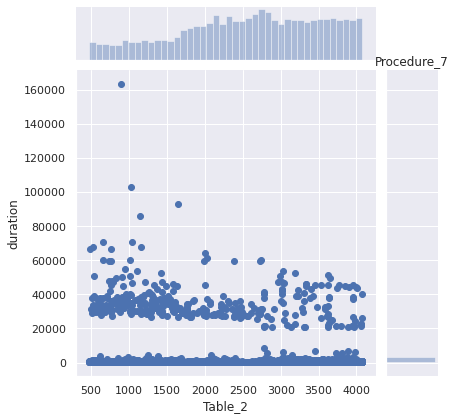

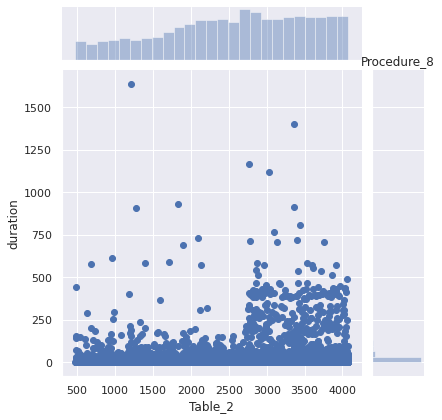

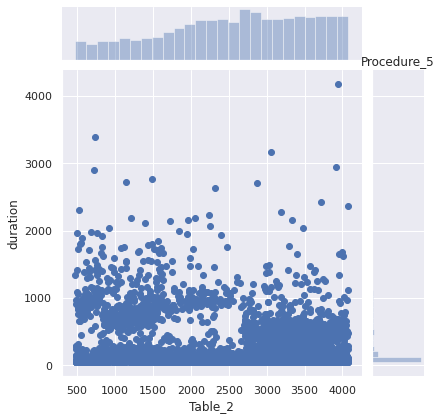

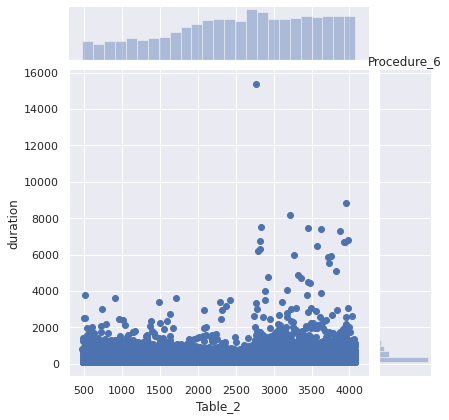

In [17]:
for index, value in top_proc_names.items():
    df = poi[poi.viewName == str(index)]
    sns.jointplot(x="Table_2", y="duration", data=df);
    plt.title(index)

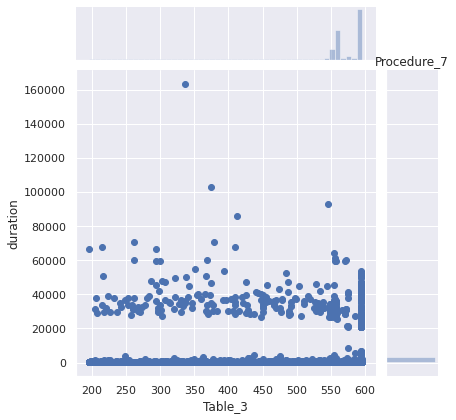

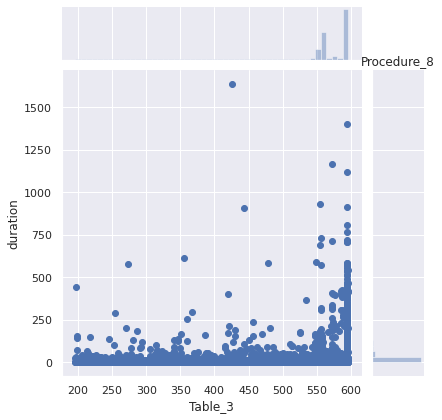

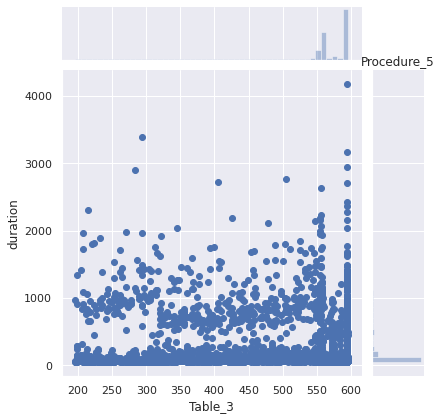

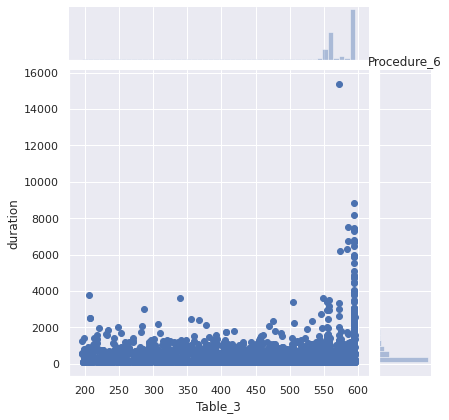

In [18]:
for index, value in top_proc_names.items():
    df = poi[poi.viewName == str(index)]
    sns.jointplot(x="Table_3", y="duration", data=df);
    plt.title(index)

In [38]:
poi.loc[:, 'second'] = poi.timestamp.apply(lambda x: round(x/1000))
time_series = poi.groupby('second').size()
time_series.describe()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


count    40300.000000
mean         1.490347
std          0.714469
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          6.000000
dtype: float64

In [41]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [42]:
poi = pd.get_dummies(poi, prefix_sep='_', drop_first=True)
poi.head()

,timestamp,duration,Table_2,Table_3,second,viewName_Procedure_4,viewName_Procedure_5,viewName_Procedure_6,viewName_Procedure_7,viewName_Procedure_8,viewName_Procedure_9
9,6386.315,97.403,476.0,199.0,6,1,0,0,0,0,0
11,7727.993,1341.620,476.0,199.0,8,0,1,0,0,0,0
13,8558.212,830.122,476.0,199.0,9,0,0,1,0,0,0
15,8688.390,130.130,476.0,199.0,9,0,0,0,1,0,0
17,8691.591,3.150,476.0,199.0,9,0,0,0,0,1,0


In [43]:
df_pois_clu = pd.DataFrame(poi, copy = True)
scaler = MinMaxScaler()

df_pois_clu_scaled=scaler.fit_transform(df_pois_clu)

start_time = time.time()
km_scores = []
db_score =[]
max_num_of_clu = 10
km_score_ = 0
for n in range(2,2+max_num_of_clu):
    cluster = KMeans(n_clusters=n).fit(df_pois_clu_scaled)
    clu = cluster.predict(df_pois_clu_scaled)
    km_scores.append(-cluster.score(df_pois_clu_scaled))
    
print('Clustering completed in {:,.2f} secs'.format(time.time()-start_time))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Clustering completed in 75.68 secs


<AxesSubplot:>

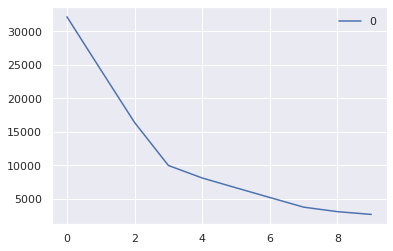

In [54]:
km_scores_df = pd.DataFrame(km_scores)
sns.lineplot(data=km_scores_df)

In [55]:
start_time = time.time()

clu_num = 3
df_pois_clu = pd.DataFrame(poi, copy = True)
scaler = MinMaxScaler()
df_pois_clu_scaled=scaler.fit_transform(df_pois_clu)

cluster = KMeans(n_clusters=clu_num).fit(df_pois_clu_scaled)
clu = cluster.predict(df_pois_clu_scaled)

poi['Cluster'] = clu

print('Clustering completed in {:,.2f} secs'.format(time.time()-start_time))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Clustering completed in 3.40 secs


In [56]:
poi.head()

,timestamp,duration,Table_2,Table_3,second,viewName_Procedure_4,viewName_Procedure_5,viewName_Procedure_6,viewName_Procedure_7,viewName_Procedure_8,viewName_Procedure_9,Cluster
9,6386.315,97.403,476.0,199.0,6,1,0,0,0,0,0,2
11,7727.993,1341.620,476.0,199.0,8,0,1,0,0,0,0,2
13,8558.212,830.122,476.0,199.0,9,0,0,1,0,0,0,2
15,8688.390,130.130,476.0,199.0,9,0,0,0,1,0,0,0
17,8691.591,3.150,476.0,199.0,9,0,0,0,0,1,0,1


In [72]:
poi.groupby('Cluster').s

,timestamp,duration,Table_2,Table_3,second,viewName_Procedure_4,viewName_Procedure_5,viewName_Procedure_6,viewName_Procedure_7,viewName_Procedure_8,viewName_Procedure_9
Cluster,,,,,,,,,,,
0,36355,36355,36355,36355,36355,36355,36355,36355,36355,36355,36355
1,7947,7947,7947,7947,7947,7947,7947,7947,7947,7947,7947
2,15759,15759,15759,15759,15759,15759,15759,15759,15759,15759,15759


In [63]:
for i in range(0,3):
    clu0 = poi[poi.Cluster==i]
    print(clu0.describe())

          timestamp       duration       Table_2       Table_3         second  \
count  3.635500e+04   36355.000000  36355.000000  36355.000000   36355.000000   
mean   7.477430e+07     535.403781   2576.189300    544.017632   74774.299161   
std    4.089859e+07    3681.317717    936.417363     84.722044   40898.585062   
min    8.688390e+03      78.904000    476.000000    196.000000       9.000000   
25%    4.089392e+07     108.068000   1923.000000    555.000000   40894.000000   
50%    7.391827e+07     124.487000   2662.000000    559.000000   73918.000000   
75%    1.099926e+08     206.641000   3356.000000    595.000000  109992.500000   
max    1.461221e+08  163248.610000   4075.000000    596.000000  146122.000000   

       viewName_Procedure_4  viewName_Procedure_5  viewName_Procedure_6  \
count               36355.0               36355.0               36355.0   
mean                    0.0                   0.0                   0.0   
std                     0.0                  